In [1]:
# 引入包
import torch
import torch.nn.functional as F
import torch.optim as optim

import torchvision.models as tv_models

import model
import imp
import utility
imp.reload(utility)
from utility import gram_matrix, ImageProcess

In [2]:
# 定义文件路径
debug = True
iter_times = 1000
uniform_h = 200
uniform_w = 200
output_img_path = "./image/output_img_v1.jpg"
style_img_path = "./image/style_img_v1.jpg"
content_img_path = "./image/content_img.jpg"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

style image shape: torch.Size([1, 3, 1200, 1920])
content image shape: torch.Size([1, 3, 681, 968])


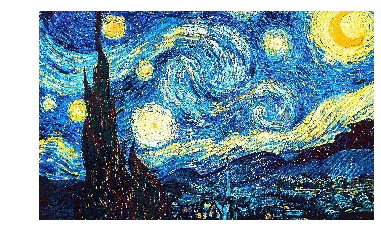

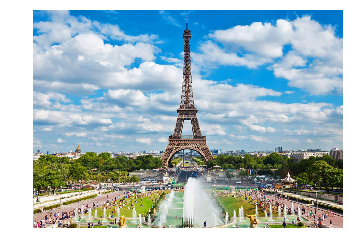

In [3]:
# 载入图片
style_img = ImageProcess.read_image(style_img_path).to(device)
print("style image shape:", style_img.shape)

content_img = ImageProcess.read_image(content_img_path).to(device)
print("content image shape:", content_img.shape)

# paint images
ImageProcess.paint_image(style_img,"style_image")
ImageProcess.paint_image(content_img,"content_image")

In [4]:
# 我们选用预训练的 VGG16
vgg16 = tv_models.vgg16(pretrained=True)

In [6]:
# 去掉 VGG16 末端的池化、压缩特征空间的几层，留出前 23 层用来提取图片特征
vgg16 = model.VGG(vgg16.features[:23]).to(device).eval() # notify all layers in eval mode
vgg16
# 注意，贾昊霖对于这里的 VGG 额外加了改动，详见 model.py。vgg(something) 不是一个 numpy.ndarray
# 而是一个四元素的 list，四个元素分别代表 3 8 15 22 层的特征图。

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [7]:
# 我们尝试获取风格图片和内容图片的特征图
style_features = vgg16(style_img)
content_features = vgg16(content_img)
if debug:
    print("style feature:")
    print([i.shape for i in style_features])   # 这是 3 8 15 22 层风格特征图的大小
    print("content feature:")
    print([i.shape for i in content_features])   # 这是 3 8 15 22 层内容特征图的大小

style feature:
[torch.Size([1, 64, 1200, 1920]), torch.Size([1, 128, 600, 960]), torch.Size([1, 256, 300, 480]), torch.Size([1, 512, 150, 240])]
content feature:
[torch.Size([1, 64, 681, 968]), torch.Size([1, 128, 340, 484]), torch.Size([1, 256, 170, 242]), torch.Size([1, 512, 85, 121])]


In [8]:
# 先把风格图片的 Gram 矩阵算出来
style_gram = [gram_matrix(i) for i in style_features]
if debug:
    print("style Gram matrix:")
    print([i.shape for i in style_gram])  # 3 8 15 22 层的风格特征图大小

style Gram matrix:
[torch.Size([1, 64, 64]), torch.Size([1, 128, 128]), torch.Size([1, 256, 256]), torch.Size([1, 512, 512])]


In [9]:
# 现在正式开始训练过程

initial_white_noise = True # 想试试白噪声开始吗？

if initial_white_noise:
    output_img = torch.randn(content_img.size()).to(device)   # 生成白噪声图像
    output_img.requires_grad_(True) # 这里注意，requires_grad 表示将这张图片认为是“需要梯度下降更新数值的参数”
else:
    output_img = content_img.clone().requires_grad_(True)  # 同样需要设定 requires_grad
optimizer = optim.LBFGS([output_img])  # 优化器

In [10]:
# 设置风格损失和特征损失的权重。style_weight 可以从 1e7 到 1e4
style_weight = 1e5
content_weight = 0.5

In [11]:
## build an list item to be a counter of the closure
it = [0]

Step 0: style_loss: 0.00330 content_loss: 12.51731


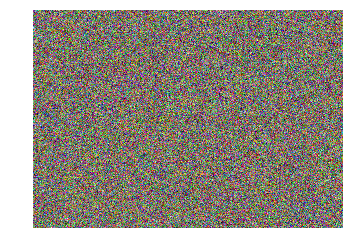

Step 20: style_loss: 0.00004 content_loss: 12.49635
Step 40: style_loss: 0.00003 content_loss: 8.90372
Step 60: style_loss: 0.00001 content_loss: 6.75288
Step 80: style_loss: 0.00001 content_loss: 5.39004
Step 100: style_loss: 0.00001 content_loss: 4.65585


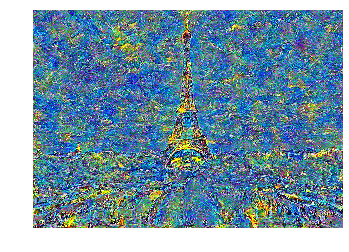

Step 120: style_loss: 0.00001 content_loss: 4.22448
Step 140: style_loss: 0.00001 content_loss: 3.94964
Step 160: style_loss: 0.00001 content_loss: 3.76667
Step 180: style_loss: 0.00001 content_loss: 3.62498
Step 200: style_loss: 0.00001 content_loss: 3.52239


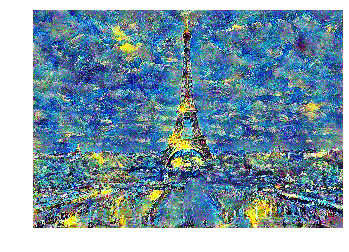

Step 220: style_loss: 0.00001 content_loss: 3.44483
Step 240: style_loss: 0.00001 content_loss: 3.38558
Step 260: style_loss: 0.00001 content_loss: 3.33915
Step 280: style_loss: 0.00001 content_loss: 3.29999
Step 300: style_loss: 0.00000 content_loss: 3.26814


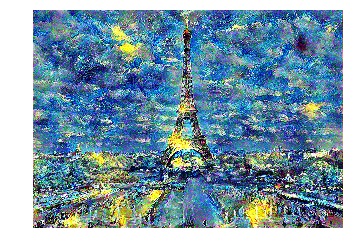

Step 320: style_loss: 0.00000 content_loss: 3.24038
Step 340: style_loss: 0.00000 content_loss: 3.21733
Step 360: style_loss: 0.00000 content_loss: 3.19741
Step 380: style_loss: 0.00000 content_loss: 3.18001
Step 400: style_loss: 0.00000 content_loss: 3.16507


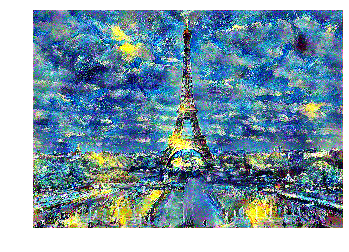

Step 420: style_loss: 0.00000 content_loss: 3.15186
Step 440: style_loss: 0.00000 content_loss: 3.14011
Step 460: style_loss: 0.00000 content_loss: 3.12965
Step 480: style_loss: 0.00000 content_loss: 3.12046
Step 500: style_loss: 0.00000 content_loss: 3.11200


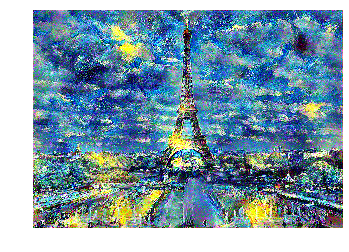

Step 520: style_loss: 0.00000 content_loss: 3.10432
Step 540: style_loss: 0.00000 content_loss: 3.09725
Step 560: style_loss: 0.00000 content_loss: 3.09071
Step 580: style_loss: 0.00000 content_loss: 3.08477
Step 600: style_loss: 0.00000 content_loss: 3.07929


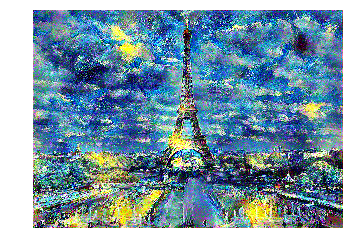

Step 620: style_loss: 0.00000 content_loss: 3.07419
Step 640: style_loss: 0.00000 content_loss: 3.06922
Step 660: style_loss: 0.00000 content_loss: 3.06460
Step 680: style_loss: 0.00000 content_loss: 3.06046
Step 700: style_loss: 0.00000 content_loss: 3.05670


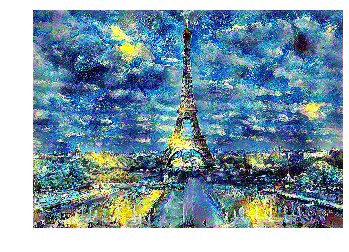

Step 720: style_loss: 0.00000 content_loss: 3.05314
Step 740: style_loss: 0.00000 content_loss: 3.04976
Step 760: style_loss: 0.00000 content_loss: 3.04652
Step 780: style_loss: 0.00000 content_loss: 3.04357
Step 800: style_loss: 0.00000 content_loss: 3.04075


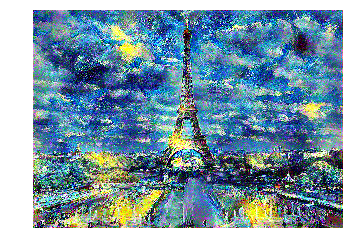

Step 820: style_loss: 0.00000 content_loss: 3.03807
Step 840: style_loss: 0.00000 content_loss: 3.03570
Step 860: style_loss: 0.00000 content_loss: 3.03317
Step 880: style_loss: 0.00000 content_loss: 3.03093
Step 900: style_loss: 0.00000 content_loss: 3.02885


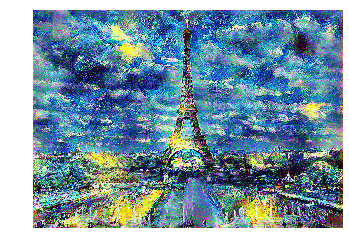

Step 920: style_loss: 0.00000 content_loss: 3.02678
Step 940: style_loss: 0.00000 content_loss: 3.02485
Step 960: style_loss: 0.00000 content_loss: 3.02296
Step 980: style_loss: 0.00000 content_loss: 3.02119


In [12]:
# 开始训练
while it[0] < iter_times:

    def closure():
        # 将所有参数的预存梯度值初始化为 0
        optimizer.zero_grad()
        # 对于输入的（同时也是我们需要生成的图像）图像，输入网络，进行前向传播。
        # 返回四个层次的特征图
        output_features = vgg16(output_img)

        # 计算输入图像的第三层（可以改成其他层）特征图和内容图像的第三层特征图平均平方误差，作为内容损失
        content_loss = F.mse_loss(input=output_features[2], target=content_features[2])
        
        # 初始化风格损失
        style_loss = 0
        # 根据前述网络对输入图像的四个层次的特征图，生成四个层次的 Gram 矩阵
        output_gram = [gram_matrix(i) for i in output_features]
        
        # style_loss 就是输入图像的 Gram 矩阵和风格图像的 Gram 矩阵（前面求过）
        # 的误差平方和
        for og, sg in zip(output_gram, style_gram):
            style_loss += F.mse_loss(input=og, target=sg)
            
        # 加权求和得到总 loss
        loss = style_loss * style_weight + content_loss * content_weight

        if it[0] % 20 == 0:
            print("Step %d: style_loss: %.5f content_loss: %.5f" % (it[0], style_loss, content_loss))
        if it[0] % 100 == 0:
            ImageProcess.paint_image(output_img, title='Output Image')

        # 对于 loss 进行反向传播，输入图片的每个像素（参数）会预存好它的梯度值以便更新
        loss.backward()
        it[0] += 1

        return loss

    # 将前述过程封装为函数 closure，传给 optimizer。
    # optimizer 会根据 closure 函数中反向传播给参数累计的梯度值，以及返回的 loss 值
    # 更新参数
    optimizer.step(closure)

In [13]:
# 把 output_img 克隆一份出来
temp_output_img = output_img.clone()

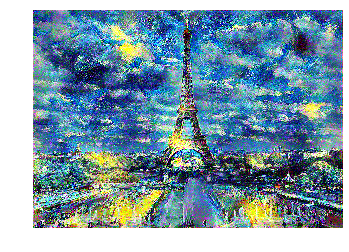

Successfully save the final stylized image to: ./image/output_img_v1.jpg


In [14]:
# print 并 save
ImageProcess.paint_image(output_img, title='Output Image')
ImageProcess.save_image(output_img, output_img_path)